In [1]:
!pip install torchsummary

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import torch.nn.functional as F
import functools
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision.utils import save_image

In [4]:
img_size = 256

img_channels = 1
seg_map_channels = 1

step_channels = 64
latent_size = 256

batch_size = 12

beta1 = 0.0 
beta2 = 0.999

lr={
    'generator': 0.0001,
    'discriminator': 0.0004
}

lambda_kld = 0.05 # weight for KLDLoss
lambda_feat = 10.0 # weight for feature matching loss 

num_workers = 4

EPOCH_START = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

DATA_PATH = '...'

LOAD_FILENAME_PATH_GENERATOR = 'weights/generator_epoch_%d.pth' %EPOCH_START
LOAD_FILENAME_PATH_DISCRIMINATOR = 'weights/discriminator_epoch_%d.pth' %EPOCH_START
LOAD_FILENAME_PATH_ENCODER = 'weights/encoder_epoch_%d.pth' %EPOCH_START

In [5]:
class Split(object):
    def __call__(self, image):
        return image[2,:,:].view(1,img_size,img_size),image[1,:,:].view(1,img_size,img_size)
    


dataset = ImageFolder(DATA_PATH, transform=transforms.Compose([
        transforms.Resize(img_size,interpolation=transforms.InterpolationMode.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
        Split()
        ]))
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=num_workers)

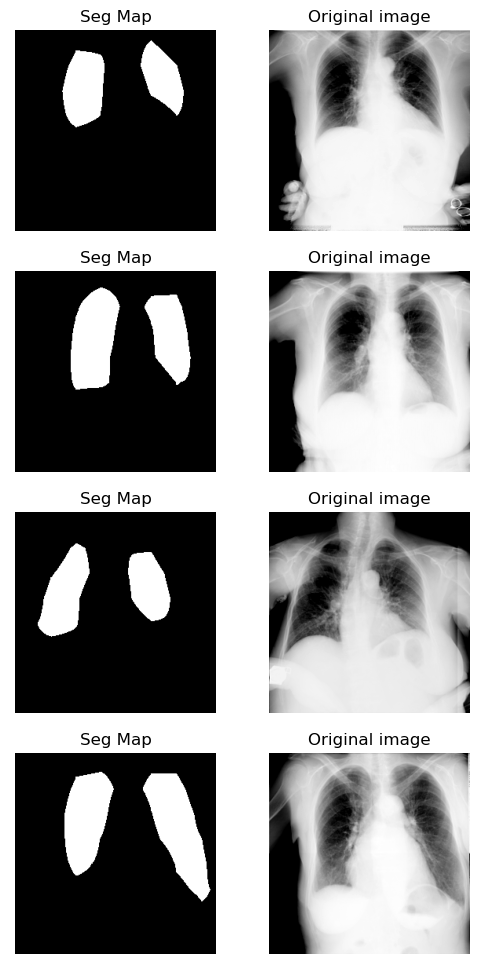

In [6]:
batch,_=next(iter(dataloader))
fig = plt.figure(figsize=(6, 12))
plt.axis("off")
title = ['Seg Map', 'Original image']

for j in range(4):
    for i in range(1,3):
        fig.add_subplot(4, 2, j*2+i)
        plt.imshow(batch[i-1][j][0], cmap='gray')
        plt.axis("off")
        plt.title(title[i-1])

In [7]:
class SPADE(nn.Module):
    def __init__(self, norm_nc, label_nc):
        super(SPADE, self).__init__()
        
        self.norm = nn.BatchNorm2d(norm_nc, affine = False)
        
        nhidden = 128
        self.shared = nn.Sequential(
            nn.Conv2d(label_nc, nhidden, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.gamma = nn.Conv2d(nhidden, norm_nc, kernel_size=3, padding=1)
        self.beta = nn.Conv2d(nhidden, norm_nc, kernel_size=3, padding=1)
        
    def forward(self, x, segmap):
        
        normalized = self.norm(x)
        
        segmap = F.interpolate(segmap, size = x.size()[2:], mode='nearest')
        act = self.shared(segmap)
        gamma = self.gamma(act)
        beta = self.beta(act)
        
        out = normalized * (1 + gamma) + beta
        
        return out

In [8]:
class SPADEResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SPADEResnetBlock, self).__init__()
        
        self.reduce_channels = (in_channels != out_channels)
        
        mid_channels = min(in_channels, out_channels)
        self.conv_0 = spectral_norm(nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1))
        self.conv_1 = spectral_norm(nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1))
        if self.reduce_channels:
            self.conv_s = spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False))
        
        self.norm_0 = SPADE(in_channels, seg_map_channels)
        self.norm_1 = SPADE(mid_channels, seg_map_channels)
        if self.reduce_channels:
            self.norm_s = SPADE(in_channels, seg_map_channels)
            
        self.act = nn.LeakyReLU(0.2)
        
    def forward(self, x, seg):
        
        if self.reduce_channels:
            x_s = self.conv_s(self.norm_s(x, seg))
        else:
            x_s = x
            
        dx = self.conv_0(self.act(self.norm_0(x, seg)))
        dx = self.conv_1(self.act(self.norm_1(dx, seg)))
        
        out = x_s + dx
        
        return out

In [9]:
class SPADEGenerator(nn.Module):
    def __init__(self, step_channels = step_channels, latent_size = latent_size):
        super(SPADEGenerator, self).__init__()
        
        self.fc = nn.Linear(latent_size, 16 * step_channels * 4 * 4)
        
        self.head_0 = SPADEResnetBlock(16 * step_channels, 16 * step_channels)

        self.G_middle_0 = SPADEResnetBlock(16 * step_channels, 16 * step_channels)
        self.G_middle_1 = SPADEResnetBlock(16 * step_channels, 16 * step_channels)

        self.up_0 = SPADEResnetBlock(16 * step_channels, 8 * step_channels)
        self.up_1 = SPADEResnetBlock(8 * step_channels, 4 * step_channels)
        self.up_2 = SPADEResnetBlock(4 * step_channels, 2 * step_channels)
        self.up_3 = SPADEResnetBlock(2 * step_channels, 1 * step_channels)
        
        self.conv_img = nn.Conv2d(1 * step_channels, img_channels, 3, padding=1)

        self.up = nn.Upsample(scale_factor=2)
        
        self.final_act = nn.Tanh()
        self.act = nn.LeakyReLU(0.2)
        
    def forward(self, seg, z = None):
        if z is None:
            z = torch.randn(seg.size(0), latent_size, dtype=torch.float32, device = device)
            
        x = self.fc(z)
        x = x.view(-1, 16 * step_channels, 4, 4)
        x = self.head_0(x, seg)

        x = self.up(x) # 8x8
        x = self.G_middle_0(x, seg)
        x = self.up(x) # 16x16
        x = self.G_middle_1(x, seg)
        
        x = self.up(x) # 32x32
        x = self.up_0(x, seg)
        x = self.up(x) # 64x64
        x = self.up_1(x, seg)
        x = self.up(x) # 128x128
        x = self.up_2(x, seg)
        x = self.up(x) # 256x256
        x = self.up_3(x, seg)
        
        x = self.conv_img(self.act(x))
        x = self.final_act(x)
        
        return x

In [10]:
#generator = SPADEGenerator()

#summary(generator,(1,256,256), device='cpu')

In [11]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, step_channels = step_channels, num_layers = 4):
        super(PatchGANDiscriminator, self).__init__()
        
        curr_channels = step_channels
        sequence = [[nn.Conv2d(seg_map_channels + img_channels, curr_channels, kernel_size = 4, 
                               stride = 2, padding = 1), 
                     nn.LeakyReLU(0.2, False)]]
        
        for n in range(1, num_layers):
            curr_channels_prev = curr_channels
            curr_channels = min(curr_channels * 2, 512)
            stride = 1 if n == num_layers - 1 else 2
            sequence += [[nn.Conv2d(curr_channels_prev, curr_channels, kernel_size = 4,
                                               stride = stride, padding = 1), nn.InstanceNorm2d(curr_channels),
                          nn.LeakyReLU(0.2, False)]]

        sequence += [[nn.Conv2d(curr_channels, 1, kernel_size = 4, stride = 1, padding = 1)]]
        
        for n in range(len(sequence)):
            self.add_module('model' + str(n), nn.Sequential(*sequence[n]))
        
    def forward(self, x):
        results = [x]
        
        for submodel in self.children():
            intermediate_output = submodel(results[-1])
            results.append(intermediate_output)
            
        # for feature matching
        return results[1:]

In [12]:
#PatchGan = PatchGANDiscriminator()

#summary(PatchGan,(2,256,256), device='cpu')

In [13]:
class MultiscaleDiscriminator(nn.Module):
    def __init__(self, num_D = 3, step_channels = step_channels, num_layers = 4):
        super(MultiscaleDiscriminator, self).__init__()
        
        for i in range(num_D):
            subnetD = PatchGANDiscriminator(step_channels, num_layers)
            self.add_module('discriminator_%d' % i, subnetD)
            
    def downsample(self, input):
        return F.avg_pool2d(input, kernel_size = 3, stride = 2, padding = [1, 1], count_include_pad = False)
    
    # returns list of lists of D outputs for feature matching
    def forward(self, x):
        result = []
        
        for name, D in self.named_children():
            out = D(x)
            result.append(out)
            x = self.downsample(x)
        
        return result

In [14]:
#multiscale = MultiscaleDiscriminator()

#summary(multiscale,(2,256,256), device='cpu')

In [15]:
class Encoder(nn.Module):
    def __init__(self, step_channels = step_channels):
        super(Encoder, self).__init__()
        
        input_channels = img_channels
        cur_channels = step_channels
        sequence = [nn.Conv2d(input_channels, cur_channels, kernel_size = 3, stride = 2, padding = 1),
                   nn.InstanceNorm2d(cur_channels), nn.LeakyReLU(0.2)]
        for i in range(1, 6):
            prev_channels = cur_channels
            cur_channels = min(cur_channels * 2, step_channels * 8)
            sequence += [nn.Conv2d(prev_channels, cur_channels, kernel_size = 3, stride = 2, padding = 1),
                        nn.InstanceNorm2d(cur_channels), nn.LeakyReLU(0.2)]
            
        self.convs = nn.Sequential(*sequence)
            
        self.fc_mu = nn.Linear(step_channels * 8 * 4 * 4, latent_size)
        self.fc_logvar = nn.Linear(step_channels * 8 * 4 * 4, latent_size)
        
    def forward(self, x):
        x = self.convs(x)
        
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

In [16]:
#encoder = Encoder()

#summary(encoder,(1,256,256), device='cpu')

Ещё можно добавить VGG-лосс, но пока что не буду.

In [17]:
def show_sample(batch):
    fig = plt.figure(figsize=(18, 18))
    plt.axis("off")
    plt.title('SegMap -> Real Image -> Generated')
    for i in range(3):
        for j in range(1,min(7, batch_size+1)):
            fig.add_subplot(3, 6, i*6+j)
            plt.imshow(np.transpose(batch[i][j-1],(1,2,0)), cmap='gray')
            plt.axis("off")
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()
    
def save_samples(samples, epoch):
    print('Saving samples')
    if not os.path.isdir('images'):
        os.mkdir('images')
    if not os.path.isdir('images/images_{}_epochs'.format(epoch)):
        os.mkdir('images/images_{}_epochs'.format(epoch))
    img_types = ['segmap', 'real_image', 'fake_image'] 
    for i in range(samples.shape[0]):
        for j in range(samples[i].shape[0]):
            save_image((samples[i][j]+1)/2. , 'images/images_{}_epochs/{}_{}.png'.format(epoch, img_types[i], j))
    print('Saving samples complete')

def save_logs(logs, epoch=0):
    if not os.path.isdir('logs'):
        os.mkdir('logs')
    txts=['losses_g','loss_g_per_batch', 'losses_d','loss_d_per_batch','real_scores','real_score_per_batch','fake_scores','fake_score_per_batch']
    for i, txt in enumerate(txts):
        with open('logs/'+txt+'_{}_epoch.txt'.format(epoch), 'w') as f:
            for e in logs[i]:
                f.write(str(e)+' ')
    
    print('Logs saved')

In [18]:
def fit(model, dataloader, criterion, epochs, lr, epochs_start=0, uploaded=False):
    
    if epochs_start!=0 and not uploaded:
        model['discriminator'].load_state_dict(torch.load(LOAD_FILENAME_PATH_DISCRIMINATOR))
        model['generator'].load_state_dict(torch.load(LOAD_FILENAME_PATH_GENERATOR))
        model['encoder'].load_state_dict(torch.load(LOAD_FILENAME_PATH_ENCODER))
        print('Model uploaded')
    
    for m in model.values():
        m = m.to(device)
        m.train()

    torch.cuda.empty_cache()
        
    # logs
    losses_g, losses_d, real_scores, fake_scores = [], [], [], []
    loss_g_per_batch, loss_d_per_batch, real_score_per_batch, fake_score_per_batch = [], [], [], []
        
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr['discriminator'], betas=(beta1, beta2)),
        "generator": torch.optim.Adam(list(model["generator"].parameters())+list(model['encoder'].parameters()),
                                      lr=lr['generator'], betas=(beta1, beta2))
    }
    
    for epoch in tqdm(range(epochs_start, epochs)):
        # logs
        loss_d_per_epoch, loss_g_per_epoch, real_score_per_epoch, fake_score_per_epoch = [], [], [], []
        
        for (segmap, real_image), _ in dataloader:
            segmap = segmap.to(device)
            real_image = real_image.to(device)
            # generator step
            G_losses = {}
            optimizer['generator'].zero_grad()
            
            # encoder step, getting z (latent vector)
            mu, logvar = model['encoder'](real_image)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = eps.mul(std) + mu
            
            G_losses['KLDLoss'] = criterion['KLDLoss'](mu, logvar) * lambda_kld
            
            fake_image = model['generator'](segmap, z)
            
            # discriminate
            fake_concat = torch.cat([segmap, fake_image], dim=1)
            real_concat = torch.cat([segmap, real_image], dim=1)
            
            # In Batch Normalization, the fake and real images are recommended to be in the same batch to avoid disparate
            # statistics in fake and real images. So both fake and real images are fed to D all at once.
            fake_and_real = torch.cat([fake_concat, real_concat], dim=0)
            
            discriminator_out = model['discriminator'](fake_and_real)
            fake_pred = []
            real_pred = []
            for p in discriminator_out:
                fake_pred.append([tensor[:tensor.size(0) // 2] for tensor in p])
                real_pred.append([tensor[tensor.size(0) // 2:] for tensor in p])
            
            # GAN loss (only outputs of discriminators)
            G_losses['GAN_loss'] = torch.FloatTensor(1).fill_(0).to(device)
            
            for pred in fake_pred:
                
                pred = pred[-1]
                
                loss_tensor = criterion['hinge_loss'](None, pred)
                
                bs = 1 if len(loss_tensor.size()) == 0 else loss_tensor.size(0)
                G_losses['GAN_loss'] += torch.mean(loss_tensor.view(bs, -1), dim=1)
                
            G_losses['GAN_loss'] /= len(fake_pred)
            
            # Feature matching loss
            G_losses['GAN_Feat_loss'] = torch.FloatTensor(1).fill_(0).to(device)
            for i in range(len(fake_pred)):
                for j in range(len(fake_pred[i]) - 1):
                    G_losses['GAN_Feat_loss'] += criterion['GAN_Feat_loss'](fake_pred[i][j], real_pred[i][j].detach()) \
                                                    * lambda_feat / len(fake_pred)
            
            # backward pass
            g_loss = sum(G_losses.values()).mean()
            g_loss.backward()
            optimizer['generator'].step()
            
            # logs 
            loss_g_per_epoch.append(g_loss.item())
            loss_g_per_batch.append(g_loss.item())
            
            # discriminator step
            D_losses = {}
            optimizer['discriminator'].zero_grad()
            # generate fake
            with torch.no_grad():
                mu, logvar = model['encoder'](real_image)
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                z = eps.mul(std) + mu

                fake_image = model['generator'](segmap, z).detach()
                fake_image.requires_grad_()
            
            fake_concat = torch.cat([segmap, fake_image], dim=1)
            real_concat = torch.cat([segmap, real_image], dim=1)
            
            # In Batch Normalization, the fake and real images are recommended to be in the same batch to avoid disparate
            # statistics in fake and real images. So both fake and real images are fed to D all at once.
            fake_and_real = torch.cat([fake_concat, real_concat], dim=0)
            
            discriminator_out = model['discriminator'](fake_and_real)
            
            fake_pred = []
            real_pred = []
            for p in discriminator_out:
                fake_pred.append([tensor[:tensor.size(0) // 2] for tensor in p])
                real_pred.append([tensor[tensor.size(0) // 2:] for tensor in p])
                
            D_losses['GAN_loss'] = torch.FloatTensor(1).fill_(0).to(device)
            
            cur_real_score = 0
            cur_fake_score = 0
            for i in range(len(fake_pred)):
                
                curr_fake_pred = fake_pred[i][-1]
                curr_real_pred = real_pred[i][-1]
                
                # logs
                cur_fake_score += torch.mean(curr_fake_pred).item()
                cur_real_score += torch.mean(curr_real_pred).item()
                
                loss_tensor = criterion['hinge_loss'](curr_real_pred, curr_fake_pred)
                
                bs = 1 if len(loss_tensor.size()) == 0 else loss_tensor.size(0)
                D_losses['GAN_loss'] += torch.mean(loss_tensor.view(bs, -1), dim=1)
                
            D_losses['GAN_loss'] /= len(fake_pred)
                            
            # backward pass
            d_loss = sum(D_losses.values()).mean()
            d_loss.backward()
            optimizer['discriminator'].step()
            
            # logs
            real_score_per_epoch.append(cur_real_score)
            real_score_per_batch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)
            fake_score_per_batch.append(cur_fake_score)
            
            loss_d_per_epoch.append(d_loss.item())
            loss_d_per_batch.append(d_loss.item())
            #break
            
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        show_sample(torch.stack((segmap, real_image, fake_image)).detach().cpu())
        
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        losses = [losses_g, loss_g_per_batch, losses_d, loss_d_per_batch, real_scores, real_score_per_batch, fake_scores, fake_score_per_batch]
        save_logs(losses, epoch = epoch + 1)
        for l in losses:
            l.clear()

        if (epoch)%1==0:
            print('Saving models')
            if not os.path.isdir('weights'):
                os.mkdir('weights')
            torch.save(model['generator'].state_dict(), 'weights/generator_epoch_{}.pth'.format(epoch+1))
            torch.save(model['discriminator'].state_dict(),'weights/discriminator_epoch_{}.pth'.format(epoch+1))
            torch.save(model['encoder'].state_dict(),'weights/encoder_epoch_{}.pth'.format(epoch+1))
            save_samples(torch.stack((segmap, real_image, fake_image)).detach().cpu(), epoch+1) #if rank=0

            print('Models saved! Epoch: %d' % (epoch+1))
            
    print('Training Done. Epochs: {}'.format(epochs))

In [19]:
def KLDLoss(mu, logvar):
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss

def hinge_loss(real_pred, fake_pred):
    if real_pred is None:
        loss = - fake_pred.mean()
    else:
        loss = torch.nn.ReLU()(1.0 + fake_pred).mean() + torch.nn.ReLU()(1.0 - real_pred).mean()
    return loss

In [20]:
from torch.nn import init

init_type = 'normal',
gain = 0.02

def init_func(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
            init.normal_(m.weight.data, 1.0, gain)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if init_type == 'normal':
            init.normal_(m.weight.data, 0.0, gain)
        elif init_type == 'xavier':
            init.xavier_normal_(m.weight.data, gain=gain)
        elif init_type == 'xavier_uniform':
            init.xavier_uniform_(m.weight.data, gain=1.0)
        elif init_type == 'kaiming':
            init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif init_type == 'orthogonal':
            init.orthogonal_(m.weight.data, gain=gain)
        elif init_type == 'none':  # uses pytorch's default init method
            m.reset_parameters()
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)

In [21]:
discriminator = MultiscaleDiscriminator()#.to(device)
discriminator.apply(init_func)

generator = SPADEGenerator()#.to(device)
generator.apply(init_func)

encoder = Encoder()#.to(device)
encoder.apply(init_func)


model = {
    'generator': generator,
    'discriminator': discriminator,
    'encoder': encoder
}

criterion = {
    'KLDLoss': KLDLoss,
    'hinge_loss': hinge_loss,
    'GAN_Feat_loss': torch.nn.L1Loss()
}

In [22]:
epochs = 80

In [ ]:
fit(model, dataloader, criterion, epochs, lr, epochs_start=EPOCH_START)